<img src="../assets/logo.png" width="50" align="left"> 

# Angle of Arrival

***

#### Prerequesites
- Sampling Data
- Range
- Doppler

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

## Intro - How Can We do Better?

<img src="../assets/protractor.png" width="400">

Unfortunately with the current hardware we have been experimenting with, we are already quickly approaching a ceiling. We have already extracted the two key pieces of information range and doppler from our radar. You may start thinking there couldn't possibly be anything else we can do. However, let's theory craft for a little bit and revisit why we could even gather this information in the first place. We were able to obtain range from understanding that our transmitted EM waves would bounce off a target. Sampling *multiple* points of this return would allow us to quantize what's at different ranges relative to the radar. Doppler was similar in that the only thing we added to our logic was sending out *multiple* chirps. Each of these chrips captured snapshots with close proximity in time such that the radar's receiver could "see" micromovements of objects and translated them into velocity readings. So, now I ask **you** what can we now do better?

Well, to lead you in the right direction, it will probably have something to do with *multiple* of something based on my forced hints in the previous paragraph. If you still need help thinking of something, what if I told you that you shouldn't limit yourself to the current hardware...

Ha! I bet some of you just thought of glueing multiple radars together which just sounds preposterous. Still, that kind of thinking is exactly what we need to move forward. Let's just tune it so that it ends up slightly more feasible than before.

## What is MIMO?

We have breifly mentioned before that the radar we have been using (or assumed we were using) has only **1 TX** and **1 RX**, or 1 transmitter and 1 receiver. This is not always the case even in some of the past exercises we have done. Humoring the thought of physically glueing together our radar to a copy of itself we can do simple math and say our radar now has (1+1) TX and (1+1) RX. Great! What does it mean though, we must get double the range resolution? No...we already proved in the range module that range resolution is a function of the signal bandwidth. To really understand what we just did and the value of it, let's learn about something called MIMO first.

MIMO is short for Multiple Input - Multiple Output and is exactly what it sounds like. In fact, by glueing together our radars we technically would have made a MIMO radar. In this kind of model, we can now utilize the fact that we have 2 TX (Multiple Outputs) that sends out two different EM waves and each of them would be received by 2 RX (Multiple Inputs). But wait, previously each of our TX would map to a single RX so doesn't this mess everything up and give us redundant data? Actually, this is a good thing and we aren't just taking a signal and naively duplicating it. In fact, we are capturing a new "perspective" of the same signal with each RX and this is important. Let's say one of our TX's sent a signal that hit an object and it was about to be received by both of our RX shortly after. Stop. We need to be very careful about how we describe the next few steps in the process.

## Angle of Arrival 

If we were to describe this without thinking, we could say "and then both RX's received the signal," which hides the point I'm trying to make. In what order did the RX receive the signal (RX 1 $\rightarrow$ RX 2 or vice versa)? How long did it take the latter to receive it? This all matters. Truth be told, we really didn't need to talk about MIMO right at this moment complete this module, but they relate in a nice way and you will see why shortly. Think about the information we get from knowing which was first and by how long. Try drawing out this event, namely draw the TX we used, the 2 RX, an object, and the signal between everything. Remember that even though the signal is traveling fast, it still must travel at a constant speed of $c$. Figure out what you can tell from knowing that one or the other RX received the signal first. What about the case when they receive the signal at the same time? Maybe your drawing looks something like this...

<img src="../assets/simple_aoa.png" width="600">

Anything to the left of the radar follows the rule that it gets receieved by RX 1 first then RX 2. This is reversed for any object on the right side of the radar. By now, I think you should be able to connect the dots and see that by "glueing" radars together we can obtain the angle of which a wave arrives. Namely, we can now **pinpoint where an object is in a new dimension**. In radar terminology, this new dimension/measurement is called **azimuth**, a fancy term for angle. We can finally put what you are seeing in the picture into words. Any object in front of the radar will force a signal to return and hit the receivers in a specific order. The timing is dependent on first the angle of the object relative to the radar (call this $\theta$), and then the distance between each RX (call this $l$). If we assume that the incoming signal is made up of roughly parallel rays, the math becomes clear and the extra path length $\Delta d$ simplifies to $l \cdot sin(\theta)$. Although this may be hard to solve directly, we can once again rely on the phases of the waves at each RX to provide more information. It turns out that the exact phase difference between the two respective signals at each RX is proportional to this $\Delta d$ term. Using a FFT will extract the approximate angle of arrival of our signal.

In code, we will go over how to take the FFT to measure azimuth...

# Processing Azimuth Information

***

## Step 1 - Range FFT

Again, let's get our range information so we get some reference of what we're looking at. We've already done this a few times, so I won't bore you. What you may want to keep in mind is that we have inserted a new dimension into our data, so there are some slight changes.

In [4]:
# Read in frame data
path = r'E:\OneDrive - UNSW\PhD\Experiments\2021-06\openradar\Presense Applied Radar\assets\doppler_example_1.npy'
frame = np.load(path)

# Manually cast to signed ints
frame.real = frame.real.astype(np.int16)
frame.imag = frame.imag.astype(np.int16)

print(f'Shape of frame: {frame.shape}')

# Meta data about the data
num_chirps = 128 # Number of chirps in the frame
num_samples = 128 # Number of ADC samples per chirp

num_tx = 2
num_rx = 4
num_vx = num_tx * num_rx # Number of virtual antennas

Shape of frame: (128, 8, 128)


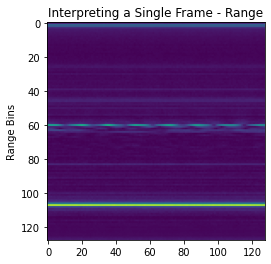

In [5]:
range_plot = np.fft.fft(frame, axis=2)

# Visualize Results
plt.imshow(np.abs(range_plot.sum(1)).T)
plt.ylabel('Range Bins')
plt.title('Interpreting a Single Frame - Range')
plt.show()

## Step 2 - Doppler FFT

We can also use the knowledge we obtained from the last module and extract doppler information from the radar data. You should know how to do this one already also.

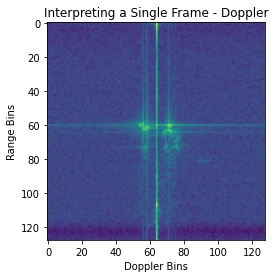

In [6]:
range_doppler = np.fft.fft(range_plot, axis=0)
range_doppler = np.fft.fftshift(range_doppler, axes=0)

# Visualize Results
plt.imshow(np.log(np.abs(range_doppler).T).sum(1))
plt.xlabel('Doppler Bins')
plt.ylabel('Range Bins')
plt.title('Interpreting a Single Frame - Doppler')
plt.show()

In [ ]:
## Step 3 - Azimuth FFT

Now for the new stuff. 

In [7]:
#################### TODO ####################
"""
    Task: Perform the range FFt on the entire frame
    Output: range_azimuth [azimuth_bins, range_bins]
    
    Details: There are three basic things you will need to do here:
                1. Zero pad each virtual antenna array (axis 1) from 8 elements to num_angle_bins elements
                2. Perform the Azimuth FFT
                3. Accumlate result over all doppler bins (for visualization purposes)
"""
num_angle_bins = 64

# Zero pad input

# Azimuth FFT

# Accumulate over all doppler bins

##############################################

In [10]:
range_doppler.shape

(128, 8, 128)

In [8]:
""" REMOVE """
padding = ((0,0), (0,num_angle_bins-range_doppler.shape[1]), (0,0))
range_azimuth = np.pad(range_doppler, padding, mode='constant')
range_azimuth = np.fft.fft(range_azimuth, axis=1)
range_azimuth = range_azimuth

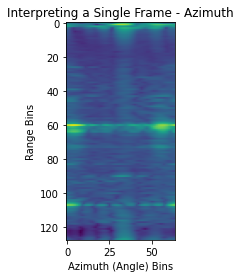

In [9]:
# Visualize Results
plt.imshow(np.log(np.abs(range_azimuth).sum(0).T))
plt.xlabel('Azimuth (Angle) Bins')
plt.ylabel('Range Bins')
plt.title('Interpreting a Single Frame - Azimuth')
plt.show()

# Extras

***

## Motivation for Other Uses

When I first learned about AOA, it was completely foreign and seemed like a specific piece of knowledge that could only be applied to the radar space. Not necessarily true. The math might change slightly, but the concepts undeniably can transfer. There are two examples off the top of my head: WiFi and smart home devices. For smart home devices, I'm talking about devices like Amazon's Alexa. If you have ever used one, you know that you need to signal the device using the phrase "hey Alexa" and it starts listening. Moreover, if you have ever looked that the device while saying that, you may have noticed that the many LED's converge in a way that points directly at you. 

## Recap

This module completes our studies of what useful information radar offers. In addition to range and doppler, we now know the basics of how we can use radar to gain **Angle of Arrival**. In short, the backscatter of an object can be analyzed to find the slight difference in time of arrival to one RX compared to another. However, we also learned that this means it is impossible to obtain  this information without **at least 2 RX**. In contrast, we gain **additional angular resolution by adding more RX (and virtual antennas)**. Since it gets physically harder to add more and more RX, we can resort to adding **additional TX as well as RX**. This creates a special model called a **Multiple Input Multiple Output** array, simulating **virtual antennas** that take the place of our RX. For example, with 2 TX and 4 RX, we have 8 virtual antennas. By adding one more TX, we now get 12 virtual antennas allowing us to get even more resolution.

## Looking Forward

After completing all the basics modules, you have learned how to begin utilizing a radar in the real world. You could quit now...or you could start learning about more advanced techniques. Somewhere along the line you may have noticed that I haven't really showed you how to do anything useful with the data we extracted. It also may seem like everything is washed down. It is. What lies ahead is exciting and will talk about new topics like **noise** and **noise removal** while we're at it, even advanced mathematical ways to improve on this AOA module called **beamforming**, and many more (dare I say **ML/DL**). I encourage you to look into more. This way you can learn how to make your very own pipeline to hopefully accomplish some substantial task and solve some real-world problem. I assure you that all these things are more involved than just taking another FFT.

***

#### Contributors
- Dash Kosaka

#### Questions, Issues, etc.?
Contact by...
- email - presenseradar@gmail.com
- github - https://github.com/presenseradar/openradar